1) Написал кастомный лосс и кастомную метрику как в задании скор ~ 2100 Релизован пункт 5 ( +5 баллов)<br>
2) Если через gridsearch перебирать гиперпараметры скор 1975 пункт 6 +5 баллов<br>
3) Если прологарифмировать таргет и переписать тот лосс который был дан в задании особых улучшений замечено не было<br>
4) добавил новые фичи пункт 1 (+ 5 баллов) повысилось качество относительно предыдущей посылки бьет бейслайн но все еще хуже чем вторая версия нужно вернуться к лоссу и метрике без логарифмирования<br>
5) Добавил Umap и Kmeans пункт 3,4 (+5/+5 баллов) видно что хорошо разделяется на 5 кластеров (пробовал разделение на другое количество там хуже)<br>
6) Если заменить loss_function на обычный 'RMSE' результаты лучше если заново запустить весь ноутбук с RMSE то итоговый скор модели 1926 ( + 3 балла)
Итого за эту домашнюю работу хотелось бы получить 20 баллов<br>
Оставил чистовой вариант работы без лишних ячеек и графиков (На паблике был 10)

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool, cv
import matplotlib.pyplot as plt
import seaborn as sns
from umap.umap_ import UMAP
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", message="n_jobs value 1 overridden")
warnings.filterwarnings("ignore", message="Graph is not fully connected")

In [2]:
train_df = pd.read_csv("train_contest.csv")
test_df  = pd.read_csv("test_contest.csv")
columns = np.array(train_df.columns)
cat_columns = [c for c in train_df.columns if c.startswith("cat")]
cont_columns = [c for c in train_df.columns if c.startswith("cont")]
target_column = 'target'
features = cat_columns + cont_columns
cat_features_idx = [features.index(c) for c in cat_columns]

In [3]:
def add_custom_features(df, *, freq_maps=None, fit=True):
    df["cont_sum"]     = df[cont_columns].sum(axis=1)
    df["cont_std"]     = df[cont_columns].std(axis=1)

    if freq_maps is None:
        freq_maps = {}

    high_card = [c for c in cat_columns if train_df[c].nunique() > 30]
    for col in high_card:
        if fit:
            freq_maps[col] = train_df[col].value_counts(normalize=True)
        df[f"{col}_freq"] = df[col].map(freq_maps[col]).fillna(0)

    return df, freq_maps


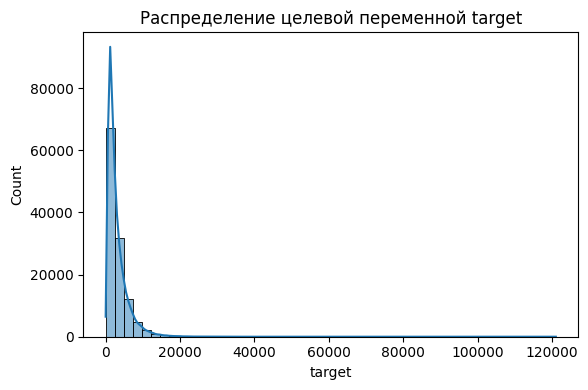

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(train_df['target'], kde=True, bins=50)
plt.title("Распределение целевой переменной target")
plt.tight_layout()
plt.show()
#прологорифмировать нужно но тогда придется менять лосс ((

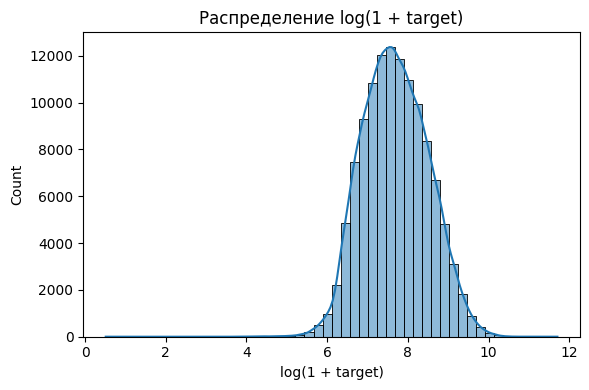

In [5]:
plt.figure(figsize=(6, 4))
sns.histplot(np.log1p(train_df['target']), kde=True, bins=50)
plt.title("Распределение log(1 + target)")
plt.xlabel("log(1 + target)")
plt.tight_layout()
plt.show()

In [25]:
class Asymmetric_custom_Metric:
    def get_metric_name(self): return "Asymmetric_custom_Metric"
    def get_description(self): return "Asymmetric_custom_Metric"
    def is_max_optimal(self):  return False
    def get_final_error(self, err, w): return math.sqrt(err / w) if w else 0.0

    def evaluate(self, approxes, targets, weight):
        EPS, ALPHA, BETA, P = 100, 1.2, 0.9, 2
        if weight is None:
            weight = [1.0] * len(approxes[0])

        err_sum, w_sum = 0.0, 0.0
        for p, y, w in zip(approxes[0], targets, weight):
            diff = p - y
            ad   = abs(diff)
            if ad > EPS:
                factor = ALPHA if diff > 0 else BETA
                err_sum += w * factor * (ad - EPS) ** P
            w_sum += w
        return err_sum, w_sum


class AsymmetricEpsilonObjective:
    
    def calc_ders_range(self, approxes, targets, weights):
        EPS, ALPHA, BETA, P = 100, 1.2, 0.9, 2
        if weights is None:
            weights = [1.0] * len(approxes)

        ders = []
        for a, y, w in zip(approxes, targets, weights):
            diff = a - y
            ad   = abs(diff)

            if ad <= EPS:
                grad = hess = 0.0
            elif diff > 0:
                grad = w * ALPHA * P * (ad - EPS) ** (P - 1)
                hess = w * ALPHA * P * (P - 1) * (ad - EPS) ** (P - 2)
            else:
                grad = -w * BETA * P * (ad - EPS) ** (P - 1)
                hess =  w * BETA * P * (P - 1) * (ad - EPS) ** (P - 2)

            ders.append((grad, hess if hess > 0 else 1e-6))
        return ders

In [7]:
train_df, freq_maps = add_custom_features(train_df, fit=True)
test_df,  _        = add_custom_features(test_df,  freq_maps=freq_maps, fit=False)

cont_columns += ["cont_sum", "cont_std"] + [f"{c}_freq" for c in freq_maps]
features      = cat_columns + cont_columns
cat_features_idx = [features.index(c) for c in cat_columns]


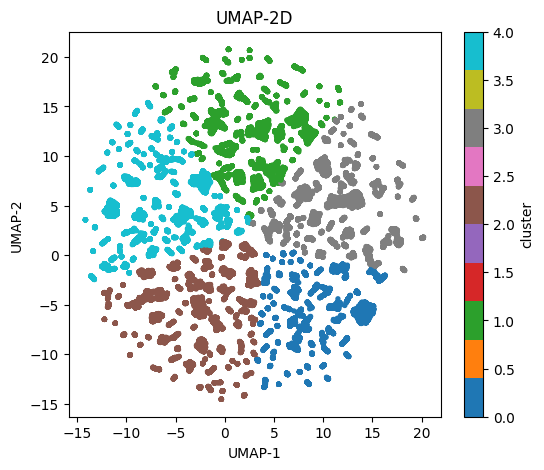

In [8]:
X_train_raw = train_df[cat_columns + cont_columns].copy()
X_test_raw  = test_df [cat_columns + cont_columns].copy()

for col in cat_columns:
    X_train_raw[col] = X_train_raw[col].astype("category").cat.codes
    X_test_raw[col]  = X_test_raw[col] .astype("category").cat.codes

umap_2d = UMAP(n_components=2, random_state=42)
train_umap = umap_2d.fit_transform(X_train_raw)
test_umap  = umap_2d.transform(X_test_raw)

kmeans = KMeans(n_clusters=5, random_state=42)
train_df["cluster"] = kmeans.fit_predict(train_umap)
test_df ["cluster"] = kmeans.predict(test_umap)

numeric_for_row = cont_columns + [f"{c}_freq" for c in freq_maps]
train_df["row_sum"] = train_df[numeric_for_row].sum(axis=1)
train_df["row_std"] = train_df[numeric_for_row].std(axis=1)
test_df ["row_sum"] = test_df [numeric_for_row].sum(axis=1)
test_df ["row_std"] = test_df [numeric_for_row].std(axis=1)

if "cluster" not in cat_columns:
    cat_columns.append("cluster")
for col in ["row_sum", "row_std"]:
    if col not in cont_columns:
        cont_columns.append(col)

features = cat_columns + cont_columns
cat_features_idx = [features.index(c) for c in cat_columns]

plt.figure(figsize=(6,5))
scatter = plt.scatter(train_umap[:,0], train_umap[:,1],
                      c=train_df["cluster"], cmap="tab10", s=8)
plt.title("UMAP‑2D")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.colorbar(scatter, label="cluster")
plt.show()


In [9]:
train_part, valid_part = train_test_split(train_df, test_size=0.2, random_state=42)
train_pool = Pool(train_part[features], label=train_part[target_column],cat_features=cat_features_idx)
valid_pool = Pool(valid_part[features], label=valid_part[target_column],cat_features=cat_features_idx)

In [27]:
BASELINE_PARAMS = dict(
    iterations         = 5000,
    learning_rate      = 0.03,
    depth              = 6,
    loss_function     = 'RMSE',
    eval_metric       = Asymmetric_custom_Metric(),
    verbose            = 200,
    early_stopping_rounds = 100,
    task_type          = 'CPU',
)

model = CatBoostRegressor(**BASELINE_PARAMS)
model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

best = model.get_best_score()
val_key = list(best["validation"].keys())[0]
print("Val Asym‑RMSE =", best["validation"][val_key])

0:	learn: 2737.9168555	test: 2724.8225121	best: 2724.8225121 (0)	total: 743ms	remaining: 1h 1m 55s
200:	learn: 1828.3010542	test: 1858.5475307	best: 1858.5475307 (200)	total: 1m 58s	remaining: 47m 15s
400:	learn: 1770.1616212	test: 1821.2159445	best: 1821.2159445 (400)	total: 4m 32s	remaining: 52m 5s
600:	learn: 1741.5289820	test: 1810.1266498	best: 1810.1266498 (600)	total: 7m 28s	remaining: 54m 45s
800:	learn: 1721.4516096	test: 1803.5410035	best: 1803.5410035 (800)	total: 10m 37s	remaining: 55m 40s
1000:	learn: 1704.5009947	test: 1799.6530818	best: 1799.6382155 (997)	total: 13m 54s	remaining: 55m 32s
1200:	learn: 1692.6848230	test: 1797.1258124	best: 1797.0914522 (1196)	total: 17m 27s	remaining: 55m 12s
1400:	learn: 1683.3956408	test: 1795.3682933	best: 1795.3367748 (1398)	total: 21m 8s	remaining: 54m 18s
1600:	learn: 1673.4720860	test: 1793.6328503	best: 1793.6328503 (1600)	total: 24m 33s	remaining: 52m 8s
1800:	learn: 1665.0439085	test: 1792.2381925	best: 1792.1991450 (1791)	total

In [28]:
param_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "depth": [2, 4, 6],
    "score_function": ["L2"]
}

best_score   = float("inf")
best_params  = {}
best_model   = None
val_key      = "Asymmetric_custom_Metric"

for i, grid_params in enumerate(ParameterGrid(param_grid), 1):
    m = CatBoostRegressor(**BASELINE_PARAMS | grid_params)
    m.fit(train_pool, eval_set=valid_pool, use_best_model=True, verbose=False)

    score = m.get_best_score()["validation"][val_key]
    print(f"{grid_params} -> {score:.5f}")

    if score < best_score:
        best_score, best_params, best_model = score, grid_params, m

print("\nBEST SCORE:", best_score, "| params:", best_params)

{'depth': 2, 'learning_rate': 0.03, 'score_function': 'L2'} -> 1902.40545
{'depth': 2, 'learning_rate': 0.05, 'score_function': 'L2'} -> 1892.58778
{'depth': 2, 'learning_rate': 0.1, 'score_function': 'L2'} -> 1898.64013
{'depth': 4, 'learning_rate': 0.03, 'score_function': 'L2'} -> 1815.75813
{'depth': 4, 'learning_rate': 0.05, 'score_function': 'L2'} -> 1817.41274
{'depth': 4, 'learning_rate': 0.1, 'score_function': 'L2'} -> 1812.56510
{'depth': 6, 'learning_rate': 0.03, 'score_function': 'L2'} -> 1783.74810
{'depth': 6, 'learning_rate': 0.05, 'score_function': 'L2'} -> 1790.16687
{'depth': 6, 'learning_rate': 0.1, 'score_function': 'L2'} -> 1784.62310

BEST SCORE: 1783.7481044247386 | params: {'depth': 6, 'learning_rate': 0.03, 'score_function': 'L2'}


In [29]:
train_full, valid_hold = train_test_split(train_df, test_size=0.15, random_state=42)
full_pool = Pool(train_full[features], label=train_full[target_column], cat_features=cat_features_idx)
hold_pool = Pool(valid_hold[features], label=valid_hold[target_column], cat_features=cat_features_idx)

final_params = BASELINE_PARAMS | best_params
final_params["verbose"] = 100
final_params["use_best_model"] = True

final_model = CatBoostRegressor(**final_params)
final_model.fit(full_pool, eval_set=hold_pool)

print("Best hold‑out AsymRMSE:",
      final_model.get_best_score()["validation"]["Asymmetric_custom_Metric"])

0:	learn: 2731.5285045	test: 2750.7198483	best: 2750.7198483 (0)	total: 2.27s	remaining: 3h 8m 54s
100:	learn: 1909.1769193	test: 1938.1642066	best: 1938.1642066 (100)	total: 2m 46s	remaining: 2h 14m 24s
200:	learn: 1815.3579520	test: 1860.7027793	best: 1860.7027793 (200)	total: 5m 48s	remaining: 2h 18m 42s
300:	learn: 1780.9617585	test: 1836.5172767	best: 1836.5172767 (300)	total: 8m 49s	remaining: 2h 17m 53s
400:	learn: 1760.3963764	test: 1824.0722012	best: 1824.0722012 (400)	total: 12m	remaining: 2h 17m 39s
500:	learn: 1744.9761765	test: 1817.1538445	best: 1817.1538445 (500)	total: 15m 25s	remaining: 2h 18m 31s
600:	learn: 1732.4459729	test: 1812.1009283	best: 1812.1009283 (600)	total: 18m 59s	remaining: 2h 19m 1s
700:	learn: 1721.4470464	test: 1809.3099509	best: 1809.3099509 (700)	total: 22m 35s	remaining: 2h 18m 31s
800:	learn: 1712.9720862	test: 1807.0953682	best: 1807.0615487 (799)	total: 26m 17s	remaining: 2h 17m 47s
900:	learn: 1704.3907164	test: 1804.8158740	best: 1804.815874

In [30]:
sample_sub = pd.read_csv("sample_submission.csv")
test_pool = Pool(test_df[features], cat_features=cat_features_idx)
preds = final_model.predict(test_pool)
preds = np.clip(preds, 0, None)

submission = sample_sub.copy()
if "index" in test_df.columns and "index" in submission.columns:
    submission = submission.sort_values("index")
submission[target_column] = preds
submission.to_csv("submission_9.csv", index=False)
submission.head()

,index,target
0,0,1594.794622
1,1,1702.221762
2,2,1743.852013
3,3,2312.961065
4,4,4450.649498
